# การรู้จำภาพใบหน้าคน 
- learning based

**Import library**

In [141]:
from tqdm import tqdm_notebook, trange #ใช้ในการ
import numpy as np
import matplotlib.pyplot as plt #ใช้ในการแสดงรูปภาพ และplot graph
%matplotlib inline

#Deep Learning Library "pytorch"
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import torchvision.models as models

#directory
from pathlib import Path
import PIL, mimetypes, os
Path.ls = lambda x:list(x.iterdir())

### Download AT&T Faces data

In [132]:
#เป็นการแตกไฟล์ dataset Face_Tr.rar
!unrar x '/content/drive/MyDrive/Colab Notebooks/Face_Tr.rar'


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/Colab Notebooks/Face_Tr.rar

Creating    Tr                                                        OK
Creating    Tr/emoji                                                  OK
Extracting  Tr/emoji/desktop.ini                                           0%  OK 
Creating    Tr/emoji/i (1)                                            OK
Extracting  Tr/emoji/i (1)/desktop.ini                                     0%  OK 
Extracting  Tr/emoji/i (1)/t (1).pgm                                       0%  OK 
Extracting  Tr/emoji/i (1)/t (2).pgm                                       1%  OK 
Extracting  Tr/emoji/i (1)/t (3).pgm                                       2%  OK 
Extracting  Tr/emoji/i (1)/t (4).pgm                                       3%  OK 
Extracting  Tr/emoji/i (1)/t (5).pgm                                       4%  OK 


In [130]:
#เชื่อมต่อgoogle drive กับ google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Explore image data

In [133]:
#กำหนดที่อยู่ของ dataset ที่นำมาใช้ 
#ที่ใส่path ในที่นี้ใช้สำหรับtest และtrain path เดียวกัน
data_path = Path('Tr/emoji')

In [134]:
#แสดงภายในที่อยู่โฟลเดอร์ของเรา
data_path.ls()

[PosixPath('Tr/emoji/desktop.ini'),
 PosixPath('Tr/emoji/i (15)'),
 PosixPath('Tr/emoji/i (12)'),
 PosixPath('Tr/emoji/i (11)'),
 PosixPath('Tr/emoji/i (1)'),
 PosixPath('Tr/emoji/i (5)'),
 PosixPath('Tr/emoji/i (6)'),
 PosixPath('Tr/emoji/i (7)'),
 PosixPath('Tr/emoji/i (8)'),
 PosixPath('Tr/emoji/i (14)'),
 PosixPath('Tr/emoji/i (13)'),
 PosixPath('Tr/emoji/i (4)'),
 PosixPath('Tr/emoji/i (3)'),
 PosixPath('Tr/emoji/i (9)'),
 PosixPath('Tr/emoji/i (2)'),
 PosixPath('Tr/emoji/i (10)')]

In [135]:
#แสดงที่อยู่ไฟล์ ภายในโฟลเดอร์ย่อย
(data_path/'i (1)').ls()

[PosixPath('Tr/emoji/i (1)/desktop.ini'),
 PosixPath('Tr/emoji/i (1)/t (1).pgm'),
 PosixPath('Tr/emoji/i (1)/t (8).pgm'),
 PosixPath('Tr/emoji/i (1)/t (4).pgm'),
 PosixPath('Tr/emoji/i (1)/t (7).pgm'),
 PosixPath('Tr/emoji/i (1)/t (2).pgm'),
 PosixPath('Tr/emoji/i (1)/t (6).pgm'),
 PosixPath('Tr/emoji/i (1)/t (3).pgm'),
 PosixPath('Tr/emoji/i (1)/t (5).pgm')]

In [137]:
#ภายในโฟลเดอร์ย่อย จะมีไฟล์desktop.ini จึงทำการลบออก
%rm 'Tr/emoji/i (1)/desktop.ini' 
%rm 'Tr/emoji/i (2)/desktop.ini' 
%rm 'Tr/emoji/i (3)/desktop.ini' 
%rm 'Tr/emoji/i (4)/desktop.ini' 
%rm 'Tr/emoji/i (5)/desktop.ini' 
%rm 'Tr/emoji/i (6)/desktop.ini' 
%rm 'Tr/emoji/i (7)/desktop.ini' 
%rm 'Tr/emoji/i (8)/desktop.ini' 
%rm 'Tr/emoji/i (9)/desktop.ini' 
%rm 'Tr/emoji/i (10)/desktop.ini' 
%rm 'Tr/emoji/i (11)/desktop.ini' 
%rm 'Tr/emoji/i (12)/desktop.ini' 
%rm 'Tr/emoji/i (13)/desktop.ini' 
%rm 'Tr/emoji/i (14)/desktop.ini' 
%rm 'Tr/emoji/i (15)/desktop.ini' 

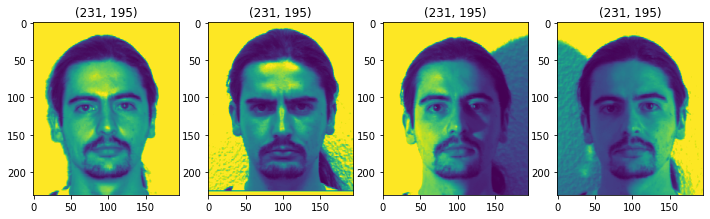

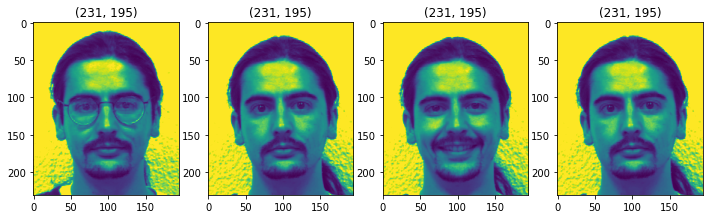

In [138]:
#สำรวจรูปภาพทั้งหมดในโฟลเดอร์ย่อยด้วยการสุ่มโฟลเดอร์
import matplotlib.image as mpimg

#สุ่มเลือกโฟลเดอร์
rand_imgs = (data_path/f'i ({np.random.randint(1,16)})').ls()

#แสดงรูปภาพทั้งหมดที่อยู่ภายในโฟลเดอร์ โดยenumerate คือคำสั่งสำหรับแจงค่าindex ให้อยู่ในรูปturple
for i,img in enumerate(rand_imgs):
    img_arr = mpimg.imread(img) #ทำการอ่านไฟล์รูปภาพ

    #กำหนดกรอบบริเวณที่ทำการแสดงภาพทั้งหมด โดยให้ 1แถว7รูปภาพ และแสดงdimension ของรูปภาพ
    if i%4 ==0: fig, axs = plt.subplots(1,4, figsize=(12,12))
    _ = axs[i%4].imshow(img_arr)
    _ = axs[i%4].set_title(img_arr.shape)

### Create image array & Data loader for model

In [142]:
from skimage import io, color
#กำหนดที่อยู่ของรูปภาพทั้งหมด และทำการเปลี่ยนเเปลงขนาดรูปภาพ = 105*105
img_tfm = transforms.Compose([
    transforms.Resize([105,105]),
    transforms.ToTensor(),
])

#กำหนดให้ข้อมูลสำหรับ train ใช้10คน หรือ10โฟลเดอร์ โฟลเดอร์ละ63รูป 
img_arr_train = torch.empty(10,8,1,105,105)

train_idxs = np.random.choice( range(1,16),size=10, replace=False) #กำหนดค่าที่ใช้จากจำนวนโฟลเดอร์ทั้งหมด15โฟลเดอร์ สุ่มออกมา10โฟลเดอร์
for i,idx in enumerate(train_idxs):
    for j,img in enumerate((data_path/f'i ({idx})').ls()): #ระบุเส้นทางของไฟล์จากการสุ่มโฟลเดอร์
        #a = PIL.Image.open(img)
        #img_arr_train[i,j] = img_tfm(PIL.ImageOps.grayscale(a))
        img_arr_train[i,j] = img_tfm(PIL.Image.open(img))#ได้รูปภาพสำหรับเทรนโฟลเดอร์ i รูปที่ j โดยรูปภาพจะถูกเปิดและเก็บใน img_tfm

#กำหนดให้ข้อมูลสำหรับ test ใช้10คน หรือ10โฟลเดอร์ โฟลเดอร์ละ63รูป 
img_arr_test = torch.empty(5,8,1,105,105)
test_idxs = [i for i in range(1,16) if not i in train_idxs] #กำหนดค่าที่ใช้จากจำนวนโฟลเดอร์ทั้งหมด15โฟลเดอร์ ที่ไม่ซ้ำกับ train_idxs
for i,idx in enumerate(test_idxs):
    for j,img in enumerate((data_path/f'i ({idx})').ls()):
        img_arr_test[i,j] = img_tfm(PIL.Image.open(img))

In [143]:
#กำหนดclass Triplet_Image_Loader สำหรับเรียนรู้การแยกใบหน้าด้วยรูปแบบหน้าต่างๆ
class Triplet_Image_Loader:
    # ปรับปรุงโค้ดจาก pairwise image loader in https://sorenbouma.github.io/blog/oneshot/
    
    def __init__(self, img_arr_train, img_arr_val): 
        self.img_arr_train = img_arr_train
        self.img_arr_val = img_arr_test
        self.n_classes, self.n_examples, self.n_ch, self.h, self.w = img_arr_train.shape #กำหนดตัวแปรจากimg_arr_train --> ลักษณะ [a, b, c, d, e]
        self.n_val = img_arr_val.size(0) #ให้ข้อมูลมีขนาดเป็น0
        
    def get_batch(self, n):#ทำหน้าที่ดึงtripletออกมาตามขนาด batch_size สำหรับ train model
        #สุ่มเลือกคลาส
        categories = np.random.choice(self.n_classes, size=(n,), replace=False) #สุ่มหยิบข้อมูลจากข้อมุลที่มีอยู่เพื่อมาสร้างเป็นประเภท
        triplets = [torch.zeros((n, self.n_ch, self.h, self.w)) for i in range(3)] #คำสั่งสร้างเลข0
        for i in range(n):
            #บันทึกประเภทจากlist
            category = categories[i]
            #สร้างรูปแบบการจัดกลุ่ม2กลุ่ม (one as anchor & one as positive example)
            idxs = np.random.choice(self.n_examples,size=2,replace=False)
            idx_anchor, idx_pos = idxs[0], idxs[1]
            triplets[0][i] = self.img_arr_train[category,idx_anchor]
            triplets[1][i] = self.img_arr_train[category,idx_pos]
            
            #สร้างรูปแบบการจัดกลุ่มอีก1กลุ่ม
            category_neg = (category + np.random.randint(1,self.n_classes)) % self.n_classes
            idx_neg = np.random.randint(0, self.n_examples)
            triplets[2][i] = self.img_arr_train[category_neg,idx_neg]

        return triplets
    
    def make_oneshot_task(self, N):#สร้างTask ไว้ทดสอบโมเดล
        
        categories = np.random.choice(self.n_val,size=(N,),replace=True) #สุ่มหยิบข้อมูลจากข้อมุลที่มีอยู่เพื่อมาสร้างเป็นประเภท
        indices = np.random.randint(0,self.n_examples,size=(N,)) #สุ่มจำนวนเต็มตัวแรกและตัวสุดท้ายของกลุ่ม
        true_category = categories[0] #เลือกข้อมูลลำดับแรกจากcategories
        ex1, ex2 = np.random.choice(self.n_examples,replace=False,size=(2,))#เลขของภาพที่อยู่ในประเภทนั้น
        test_image = torch.stack([self.img_arr_val[true_category,ex1]]*N) #การรวมค่าเข้าไปในtensorพร้อมกับDimensionใหม่ ได้ภาพที่จะใช้ทดสอบ
        support_set = self.img_arr_val[categories,indices] #เลือกประเภทภาพแล้วรูปภาพที่ใกล้เคียงกัน
        support_set[0] = self.img_arr_val[true_category,ex2] #เลือกประเภทภาพอันแรกจากsupportset  แล้วเลือกภาพมาให้เป็นตัวอย่างที่2
        pairs = [test_image,support_set] #นำภาพที่ใช้ทดสอบ กับเซ็ตของภาพที่ใกล้เคียงกันมาอยู่ในarray
        targets = torch.zeros((N,))
        targets[0] = 1
        return pairs, targets

    
    def test_oneshot(self,model, N, k):
        
        model.eval()
        n_correct = 0
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N)
            dists = model.get_distance(*inputs).cpu().detach().numpy()
            if np.argmin(dists) == 0:
                n_correct += 1
        pct_correct = (63*n_correct / k)
        
        return pct_correct

In [144]:
#เรียกใช้triplet image  loader และกำหนดตัวแปร
triplet_dl = Triplet_Image_Loader(img_arr_train,img_arr_test)

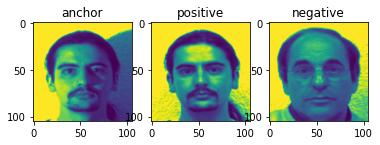

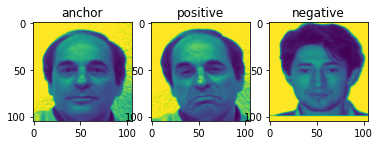

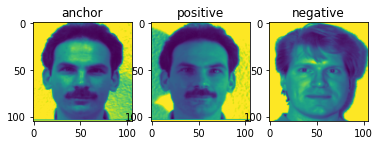

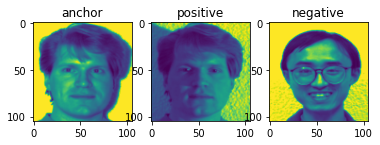

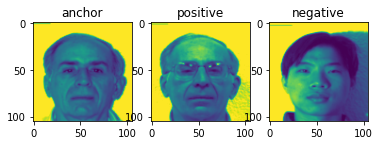

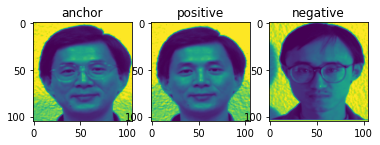

In [145]:
#ทดสอบฟังก์ชัน
triplets = triplet_dl.get_batch(6)
for anchor, pos, neg in zip(triplets[0], triplets[1], triplets[2]):
    fig, axs = plt.subplots(1,3)
    _=axs[0].imshow(anchor.numpy().squeeze(0))
    _=axs[0].set_title('anchor')
    _=axs[1].imshow(pos.numpy().squeeze(0))
    _=axs[1].set_title('positive')
    _=axs[2].imshow(neg.numpy().squeeze(0))
    _=axs[2].set_title('negative')
    plt.show()

### Define model architecture

In [146]:
#ใช้คำนวณclassification
def get_fc_layers(fc_sizes, ps):
    fc_layers_list = []
    for ni,nf,p in zip(fc_sizes[:-1], fc_sizes[1:], ps):
        fc_layers_list.append(nn.Linear(ni, nf))
        fc_layers_list.append(nn.ReLU(inplace=True))
        fc_layers_list.append(nn.BatchNorm1d(nf))
        fc_layers_list.append(nn.Dropout(p=p))
    return nn.Sequential(*fc_layers_list)

#ใช้ Resnet34 มาเป็น CNN network สำหรับสกัดคุณลักษณะจากรูปภาพ    
class Resnet34FeatureExtractor(nn.Module):
    def __init__(self,n_ch=3,feat_dim=128,pretrained=True):
        super().__init__()
        
        # validate input channel
        assert n_ch in [1,3]
        
        self.feat_dim = feat_dim
        resnet34 = models.resnet34(pretrained=pretrained)
        # change input channel according to the input data
        resnet34.conv1 = nn.Conv2d(n_ch,64,kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.body = nn.Sequential(*nn.ModuleList(resnet34.children())[:-1])
        self.dense = get_fc_layers(fc_sizes=[512,1024,1024,feat_dim],ps=[.5,.5,.5])

    def forward(self, input):
        output = self.body(input)
        output = torch.flatten(output,1)
        output = self.dense(output)
        return output

In [147]:
'''
กำหนดโครงสร้าง neural network โดยใช้ CNN เป็นตัวสกัดคุณลักษณะ และใช้ผลลัพธ์ที่เป็นค่าระยะห่างที่เป็น Positive and negative ที่เป็นตัวอย่างให้กับภาพหลัก
define architecture of NN that use CNN as image feature extractor (as defined above) and
output distance of positive and negative example to anchor image
'''
class TripletNet(nn.Module):
    
    def __init__(self, feature_extractor_module: nn.Module):
        super().__init__()
        self.feature_extractor = feature_extractor_module
    
    #จะได้ค่าระยะห่างใบหน้า ของรูปที่ทำการtest
    def get_distance(self,img1,img2):
        img1, img2 = img1.to(device), img2.to(device)
        img1_feat, img2_feat = self.feature_extractor(img1), self.feature_extractor(img2)
        return F.pairwise_distance(img1_feat,img2_feat,p=2.0,keepdim=True)
    
    def forward(self,input):
        anchor, pos, neg = input
        p_dist = self.get_distance(anchor, pos)
        n_dist = self.get_distance(anchor, neg)
        return (p_dist, n_dist)

In [148]:
#ผลต่างระหว่าง Euclidean distance ระหว่างใบหน้าเดียวกัน originally defined in https://arxiv.org/pdf/1503.03832
class TripletLoss(nn.Module):
    def __init__(self, alpha=0.2):
        super().__init__()
        self.alpha = alpha
        
    def forward(self, input):
        p_dist, n_dist = input
        torch.Size([1,1024])
        return torch.mean(torch.max(p_dist - n_dist + self.alpha, torch.zeros_like(p_dist)),0)

### Train model

In [162]:
#ส่วนของการTrain model
class CancelTrainException(Exception): pass

class LRFinderTriplet:
    
    def __init__(self, model, data_loader, bs, loss_func, opt, lr_range, max_iter):
        self.lrs = []
        self.losses = []
        self.model = model
        self.data_loader = data_loader
        self.bs = bs
        self.loss_func = loss_func
        self.opt = opt
        self.lr_range = lr_range
        self.max_iter = max_iter
    
    def run(self): #สูตรที่ใช้คำนวณค่าต่างๆ
        best_loss = 1e9
        for i in trange(self.max_iter):
            # begin batch
            pos = i/self.max_iter
            lr = self.lr_range[0]*(self.lr_range[1]/self.lr_range[0])**pos
            for pg in self.opt.param_groups: pg['lr'] = lr

            xb = self.data_loader.get_batch(self.bs)
            loss = self.loss_func(self.model(xb))
            loss.backward()
            self.opt.step()
            self.opt.zero_grad()

            # after step
            if loss.item() > best_loss*10: raise CancelTrainException()
            if loss.item() < best_loss: best_loss = loss.item() 

            # after batch
            self.lrs.append(lr)
            self.losses.append(loss.item())
    
    def plot_lr(self): #plot ค่า loss ที่ learning rate ต่างๆ
        # plot lr x loss
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

In [150]:
# ฟังก์ชันสำหรับการคำนวณประสิทธิภาพของโมเดล
def train_n_batch_triplet(n, data_loader, loss_func, model, opt, bs, eval_every, loss_every, N_way, n_val, model_path):
    
    for i in tqdm_notebook(range(n)):
        xb = data_loader.get_batch(bs)
        loss = loss_func(model(xb))
        loss.backward()
        opt.step()
        opt.zero_grad()
        best_acc = 0
        # evaluate #แสดงค่าaccuracy
        if (i%eval_every==0) & (i!=0):
            val_acc = data_loader.test_oneshot(model,N_way,n_val)
            print(f"validation accuracy on {N_way} supports of total {n_val} set:{val_acc}")
            if val_acc >= best_acc:
                print("saving")
                torch.save(model.state_dict(),model_path)
                best=val_acc
        if i % loss_every == 0: #แสดงค่าlossทุกครั้งๆ ในรอบที่กำหนด และทุกรอบที่มีการloss
            print("iteration {}, training loss: {:.2f},".format(i,loss.item()))


Find optimal learning rate

In [164]:
#วัดประสิทธิภาพการรันของโมเดลว่าสามารถเรียนรู้ได้กี่% ภายในจำนวนรอบและระยะเวลาที่กำหนด
triplet_dl = Triplet_Image_Loader(img_arr_train, img_arr_test)
model = TripletNet(feature_extractor_module=Resnet34FeatureExtractor(n_ch=1,feat_dim=128,pretrained=False)).to(device)
loss_func = TripletLoss(.8)
optimizer = optim.Adam(model.parameters(), lr=5e-5)
lr_finder = LRFinderTriplet(model=model, data_loader=triplet_dl, bs=8, loss_func=loss_func, opt=optimizer,
                     lr_range=[1e-7,1], max_iter=120)
lr_finder.run()














  0%|          | 0/120 [00:00<?, ?it/s]












  1%|          | 1/120 [00:05<10:47,  5.44s/it]












  2%|▏         | 2/120 [00:10<10:39,  5.42s/it]












  2%|▎         | 3/120 [00:16<10:29,  5.38s/it]












  3%|▎         | 4/120 [00:21<10:17,  5.32s/it]












  4%|▍         | 5/120 [00:26<10:09,  5.30s/it]












  5%|▌         | 6/120 [00:31<10:04,  5.30s/it]












  6%|▌         | 7/120 [00:37<09:54,  5.26s/it]












  7%|▋         | 8/120 [00:42<09:50,  5.28s/it]












  8%|▊         | 9/120 [00:47<09:40,  5.23s/it]












  8%|▊         | 10/120 [00:52<09:36,  5.24s/it]












  9%|▉         | 11/120 [00:57<09:31,  5.25s/it]












 10%|█         | 12/120 [01:03<09:24,  5.22s/it]












 11%|█         | 13/120 [01:08<09:21,  5.24s/it]












 12%|█▏        | 14/120 [01:13<09:13,  5.22s/it]












 12%|█▎        | 15/120 [01:18<09:08,  5.22s/it]












 13%|█▎        | 16/120 [01:2

CancelTrainException: ignored

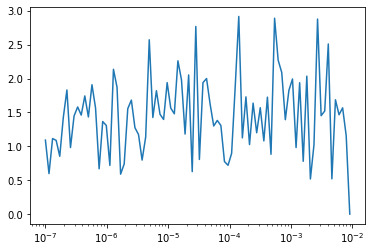

In [165]:
lr_finder.plot_lr()

Train the model

In [168]:
triplet_dl = Triplet_Image_Loader(img_arr_train,img_arr_test)
model = TripletNet(feature_extractor_module=Resnet34FeatureExtractor(n_ch=1,feat_dim=128,pretrained=False)).to(device)
loss_func = TripletLoss(.3)
optimizer = optim.Adam(model.parameters(),lr=2e-5)

train_n_batch_triplet(n=200, data_loader=triplet_dl, loss_func=loss_func, model=model, opt=optimizer, bs=8,
              eval_every=100, loss_every=50, N_way=8, n_val=80, model_path='model.pt')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


iteration 0, training loss: 1.02,
iteration 50, training loss: 1.66,
validation accuracy on 8 supports of total 80 set:12.6
saving
iteration 100, training loss: 1.75,
iteration 150, training loss: 3.64,



### Test the model on one-shot task

base image


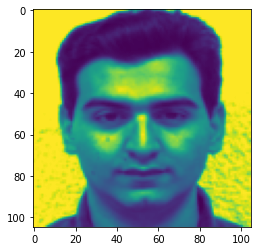

support set


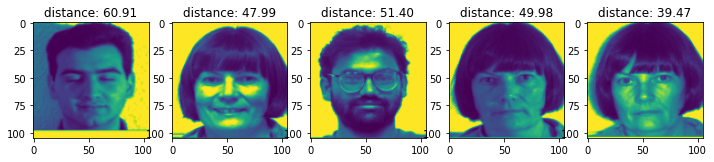

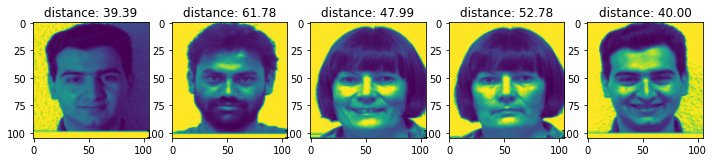

In [152]:
# randomly test the model with one-shot task
input, target = triplet_dl.make_oneshot_task(10)

# show base image
print('base image')
plt.imshow(input[0][0].numpy().squeeze(0))
plt.show()
# show support set image with probability
print('support set')
for i in range(len(input[1])):
    if i%5==0: fig, axs = plt.subplots(1,5, figsize=(12,12))
    _ = axs[i%5].imshow(input[1][i].numpy().squeeze(0))
    _= axs[i%5].set_title('distance: {:3.2f}'.format(model.get_distance(input[0][i].unsqueeze(0),input[1][i].unsqueeze(0)).item()))
   

In [110]:
pip install torchsummary

In [175]:
from torchvision import models
from torchsummary import summary

vgg = models.vgg16()
summary(vgg, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,